# Create-Adversarial-Attack

Adversarial Attack is generated specifically to corrupt models that classify videos.

code by:

    Krishna Srikar Durbha - EE18BTECH11046

## Imports

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import imageio
import cv2
import scipy
import os
import random
from sklearn.metrics import accuracy_score

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, LSTM, GRU, Dropout, Reshape, Conv1D, MaxPooling1D, MaxPooling2D, Concatenate

# Installing tqdm
!pip3 install tqdm
from tqdm import tqdm

### Connecting to Google Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Video-Classification

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1hWjYhkpzbh9RH61Vx5nqJI95R58avujK/Video-Classification


### Importing Dataset

In [3]:
# Path for Videos and Features
Videos_Path = "Datasets/Videos"
Features_Path = "Datasets/Features"

# Interested no.of classes
N = 30

# Test Image
Test_Image = np.repeat(np.expand_dims(cv2.resize(pimg.imread("Datasets/Image.jpg"), (128,128)), axis=0), 20, axis=0)

# Classes
Classes = os.listdir(Features_Path)
Classes.sort()
Classes = Classes[:N]
Classes2Index = dict(zip(Classes, np.arange(len(Classes))))
Index2Classes = dict(zip(np.arange(len(Classes)), Classes))

## Constructing Classification Model

Constructing a complete end-to-end classification model using InceptionNetV3 and Classification RNN Network.

Feature Extraction Model and Classifier

In [4]:
# Feature Extraction Model
FeatureExtractor = tf.keras.models.load_model("Models/Feature-Extraction_Model.h5")

# Classifier
Classifier = tf.keras.models.load_model("Models/Video-Classification_Model.h5")

# Input Preprocessing Function
Preprocess_Input = tf.keras.applications.inception_v3.preprocess_input

Constructing End-to-End Model

In [5]:
def End2EndModel(Num_Frames=20):
    In = Input(shape=(Num_Frames,128,128,3))
    x = tf.reshape(In, (-1,128,128,3))
    x = FeatureExtractor(x)
    x = tf.reshape(x,(-1,20,2048))
    Ou = Classifier(x)
    return tf.keras.Model(In, Ou)    

Creating Model

In [6]:
tf.keras.backend.clear_session()

# Creating Model
ClassificationModel = End2EndModel()
ClassificationModel.trainable = False

# Summary
ClassificationModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 128, 128, 3)  0         
                             ]                                   
                                                                 
 tf.reshape (TFOpLambda)     (None, 128, 128, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 tf.reshape_1 (TFOpLambda)   (None, 20, 2048)          0         
                                                                 
 model (Functional)          (None, 30)                29281438  
                                                                 
Total params: 51,084,222
Trainable params: 0
Non-trainable params: 51,084,222
_________________________________________________

## Data Processing

Extracting Frames from Video

In [7]:
def ExtractFrames(Path, resize=(128, 128)):
    cap = cv2.VideoCapture(Path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
    finally:
        cap.release()
    return np.array(frames)

Extract **N** random frames from Video

In [8]:
def Frames_Selection(Path, Num_Frames, resize=(128, 128)):
    Frames = ExtractFrames(Path, resize)
    Indices = np.random.choice(np.arange(Frames.shape[0]), size=Num_Frames, replace=False)
    return Frames[Indices]

Visualisation

In [9]:
def Visualise(img1, img2, Path):
    plt.figure(figsize=(18,18))

    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.title("Without Noise")

    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.title("With Noise")

    if img2.dtype == np.int:
        imageio.imwrite(Path, np.uint8(img2))
    else:
        imageio.imwrite(Path, np.uint8(255.0*img2))

    plt.show()

## Testing

Creating a functions to classify videos with and without adversarial-attack



Predict the label from frames

In [10]:
def Predict(ClassificationModel, X):
    if X.dtype == np.float and np.max(X) <= 1.0:
        X = np.uint8(X * 255.0)

    X = Preprocess_Input(X)
    y_pred = ClassificationModel.predict(np.expand_dims(X, axis=0))
    label = Index2Classes[np.argmax(y_pred)]
    return label

Understanding impacts on performance due to noise

In [11]:
def Performance(ClassificationModel, Videos_Path, AttackFunction, corrupt_indices, Num_Frames=20, Num_Samples=10):
    Indices = np.array([31, 84, 67, 88, 55, 82, 50, 17, 63, 59, 70, 46, 37, 86, 93,  2, 28,
       51, 69, 74, 30, 90, 61, 49, 41, 71, 94,  9, 27, 24, 40, 92, 21, 79,
       81, 95,  3, 87, 16, 62, 72,  6, 60,  5, 56, 19, 47, 45, 68, 29, 11,
       44, 58, 15, 43, 97, 76, 53, 96, 13, 12, 18,  4, 57, 48, 64, 39,  8,
       38, 25, 26, 66, 98,  7, 14, 36, 77,  0, 54, 73, 65, 22, 52, 99, 33,
       75, 80, 83, 10, 89, 34, 85, 91,  1, 78, 35, 32, 42, 20, 23])
    ValidIndices = Indices[80:]
    Class_Accuracy = []
    Class_Accuracy_Attack = []

    for c in Classes:
        All_Files =  list(reversed(sorted(os.listdir(Videos_Path+"/"+c))))
        files = np.array(All_Files)[ValidIndices]

        y = []
        y_pred = []
        y_pred_Attack = []
        for i in tqdm(range(files.shape[0]), desc=str(c)):
            # Selecting Frames
            Frames = Frames_Selection(Videos_Path+"/"+c+"/"+files[i], Num_Frames)
            Adversarial_Frames = np.copy(Frames)
            
            # Attack
            Adversarial_Frames = AttackFunction(ClassificationModel, Adversarial_Frames, np.eye(N)[Classes2Index[c]], corrupt_indices)

            # Predicting Labels
            y.append(c)
            y_pred.append(Predict(ClassificationModel, Frames))
            y_pred_Attack.append(Predict(ClassificationModel, Adversarial_Frames))
        
        Accuracy = accuracy_score(y, y_pred)
        Accuracy_Attack = accuracy_score(y, y_pred_Attack)
        Class_Accuracy.append(Accuracy)
        Class_Accuracy_Attack.append(Accuracy_Attack)
        
        print ("\nClass:",c)
        print ("Accuracy without " + AttackFunction.__name__ + " = " + str(Accuracy))
        print ("Accuracy with " + AttackFunction.__name__ + " = " + str(Accuracy_Attack))
        print ("Accuracy between Predictions = ", accuracy_score(y_pred, y_pred_Attack))
        print ("-"*100)
        print ("\n")

    return Class_Accuracy,Class_Accuracy_Attack

## Impact of Adversarial Attack



Loss Function of Adversarial Attack and Optimizer of Attack

In [12]:
Loss_Fn = tf.keras.losses.CategoricalCrossentropy()

def LossFunction(y, y_pred, M, E, l=0.01):
    Loss1 = Loss_Fn(y, y_pred)
    Loss2 = tf.cast(tf.math.reduce_sum(tf.math.sqrt(tf.math.reduce_sum(tf.math.square(tf.multiply(M,E)), axis=(1,2,3)))), tf.float32)
    return tf.add(Loss1, -l*Loss2)

Compute Gradient

In [13]:
def compute_gradient(Model, LossFunction, X, y, M, E):
    with tf.GradientTape() as tape:
        tape.watch(X)
        
        # Predict
        y_pred = ClassificationModel(Preprocess_Input(tf.expand_dims(255.0 * X, axis=0)))
        
        # Calculating Loss
        loss = LossFunction(y, y_pred, M, E)
    
    # Returning Gradients
    return tape.gradient(loss, X)

Adversarial Attack

In [14]:
def AdversarialAttack(Model, Frames, y, corrupt_indices, num_iterations=100, epsilon=0.2):
    # Frames of [0,255] to [0.0,1.0]
    Frames = Frames/255.0
    
    # Temporal Mask
    M = np.zeros((Frames.shape))
    M[corrupt_indices] = 1
    M = tf.Variable(M)

    # Adversarial Perturbation
    E = (1e-4)*np.ones((Frames.shape))
    E = tf.Variable(E)

    Adv_X = tf.identity(tf.Variable(Frames)) + tf.multiply(M, E)

    for i in range(num_iterations):
        grads = compute_gradient(Model, LossFunction, Adv_X, np.array([y]), M, E)
        Adv_X = tf.Variable(Frames) + epsilon*tf.sin(grads)
        Adv_X = tf.clip_by_value(Adv_X, 0.0, 1.0)

        if Classes2Index[Predict(Model, Adv_X.numpy())] == np.argmax(y):
            continue
        else:
            break

    return Adv_X.numpy()

Visualisation

True Label = CricketBowling
Predicted Label = Fencing


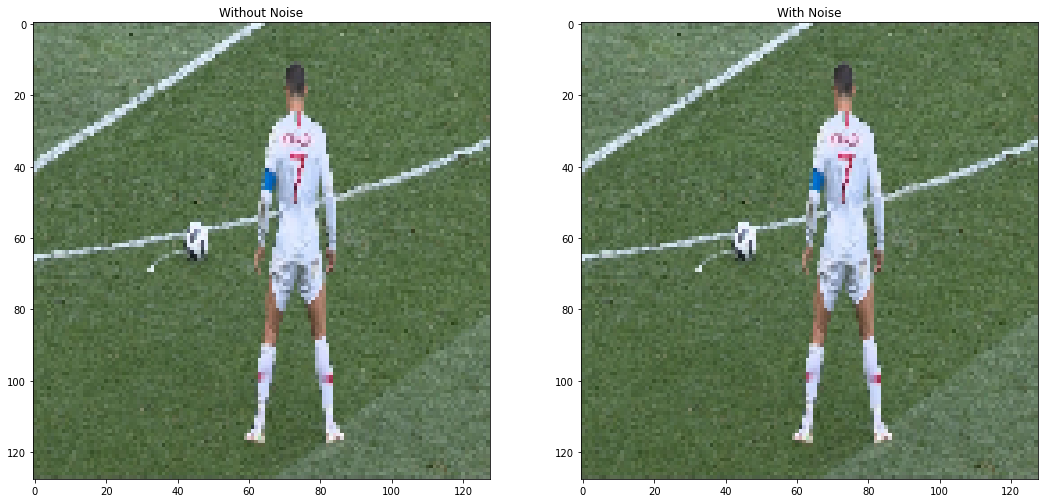

In [15]:
# Attack
img1 = np.copy(Test_Image)
y_pred = Predict(ClassificationModel, img1)

img2 = AdversarialAttack(ClassificationModel, np.copy(Test_Image), np.eye(30)[Classes2Index[y_pred]], corrupt_indices=np.array([0,4,9,13]))

print ("True Label =", y_pred)
print ("Predicted Label =", Predict(ClassificationModel, img2))

Visualise(img1[0],img2[0], "Results/Adversarial-Attack.png")

Performance when four frames are corrupted. Indices of corrputed frames is $[0,4,9,13]$

In [16]:
Accuracy, Accuracy_Attackf4 = Performance(ClassificationModel, Videos_Path, AdversarialAttack, corrupt_indices=np.array([0,4,9,13]))

ApplyEyeMakeup: 100%|██████████| 20/20 [01:02<00:00,  3.14s/it]



Class: ApplyEyeMakeup
Accuracy without AdversarialAttack = 0.8
Accuracy with AdversarialAttack = 0.05
Accuracy between Predictions =  0.15
----------------------------------------------------------------------------------------------------




ApplyLipstick: 100%|██████████| 20/20 [03:13<00:00,  9.67s/it]



Class: ApplyLipstick
Accuracy without AdversarialAttack = 0.9
Accuracy with AdversarialAttack = 0.2
Accuracy between Predictions =  0.3
----------------------------------------------------------------------------------------------------




Archery: 100%|██████████| 20/20 [03:15<00:00,  9.79s/it]



Class: Archery
Accuracy without AdversarialAttack = 0.95
Accuracy with AdversarialAttack = 0.2
Accuracy between Predictions =  0.2
----------------------------------------------------------------------------------------------------




BabyCrawling: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]



Class: BabyCrawling
Accuracy without AdversarialAttack = 0.75
Accuracy with AdversarialAttack = 0.0
Accuracy between Predictions =  0.2
----------------------------------------------------------------------------------------------------




BalanceBeam: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]



Class: BalanceBeam
Accuracy without AdversarialAttack = 0.75
Accuracy with AdversarialAttack = 0.0
Accuracy between Predictions =  0.2
----------------------------------------------------------------------------------------------------




BandMarching: 100%|██████████| 20/20 [03:19<00:00,  9.99s/it]



Class: BandMarching
Accuracy without AdversarialAttack = 0.95
Accuracy with AdversarialAttack = 0.2
Accuracy between Predictions =  0.25
----------------------------------------------------------------------------------------------------




BaseballPitch: 100%|██████████| 20/20 [01:45<00:00,  5.28s/it]



Class: BaseballPitch
Accuracy without AdversarialAttack = 0.95
Accuracy with AdversarialAttack = 0.1
Accuracy between Predictions =  0.15
----------------------------------------------------------------------------------------------------




Basketball: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]



Class: Basketball
Accuracy without AdversarialAttack = 0.95
Accuracy with AdversarialAttack = 0.0
Accuracy between Predictions =  0.05
----------------------------------------------------------------------------------------------------




BasketballDunk: 100%|██████████| 20/20 [07:35<00:00, 22.77s/it]



Class: BasketballDunk
Accuracy without AdversarialAttack = 0.95
Accuracy with AdversarialAttack = 0.5
Accuracy between Predictions =  0.55
----------------------------------------------------------------------------------------------------




BenchPress: 100%|██████████| 20/20 [01:44<00:00,  5.21s/it]



Class: BenchPress
Accuracy without AdversarialAttack = 1.0
Accuracy with AdversarialAttack = 0.1
Accuracy between Predictions =  0.1
----------------------------------------------------------------------------------------------------




Biking: 100%|██████████| 20/20 [03:58<00:00, 11.95s/it]



Class: Biking
Accuracy without AdversarialAttack = 0.9
Accuracy with AdversarialAttack = 0.25
Accuracy between Predictions =  0.35
----------------------------------------------------------------------------------------------------




Billiards: 100%|██████████| 20/20 [12:37<00:00, 37.88s/it]



Class: Billiards
Accuracy without AdversarialAttack = 1.0
Accuracy with AdversarialAttack = 0.85
Accuracy between Predictions =  0.85
----------------------------------------------------------------------------------------------------




BlowDryHair: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]



Class: BlowDryHair
Accuracy without AdversarialAttack = 0.95
Accuracy with AdversarialAttack = 0.0
Accuracy between Predictions =  0.05
----------------------------------------------------------------------------------------------------




BlowingCandles: 100%|██████████| 20/20 [02:28<00:00,  7.43s/it]



Class: BlowingCandles
Accuracy without AdversarialAttack = 0.9
Accuracy with AdversarialAttack = 0.15
Accuracy between Predictions =  0.2
----------------------------------------------------------------------------------------------------




BodyWeightSquats: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]



Class: BodyWeightSquats
Accuracy without AdversarialAttack = 0.6
Accuracy with AdversarialAttack = 0.0
Accuracy between Predictions =  0.35
----------------------------------------------------------------------------------------------------




Bowling: 100%|██████████| 20/20 [06:50<00:00, 20.54s/it]



Class: Bowling
Accuracy without AdversarialAttack = 0.95
Accuracy with AdversarialAttack = 0.45
Accuracy between Predictions =  0.45
----------------------------------------------------------------------------------------------------




BoxingPunchingBag: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]



Class: BoxingPunchingBag
Accuracy without AdversarialAttack = 1.0
Accuracy with AdversarialAttack = 0.05
Accuracy between Predictions =  0.05
----------------------------------------------------------------------------------------------------




BoxingSpeedBag: 100%|██████████| 20/20 [01:07<00:00,  3.38s/it]



Class: BoxingSpeedBag
Accuracy without AdversarialAttack = 1.0
Accuracy with AdversarialAttack = 0.05
Accuracy between Predictions =  0.05
----------------------------------------------------------------------------------------------------




BreastStroke: 100%|██████████| 20/20 [03:15<00:00,  9.79s/it]



Class: BreastStroke
Accuracy without AdversarialAttack = 1.0
Accuracy with AdversarialAttack = 0.2
Accuracy between Predictions =  0.2
----------------------------------------------------------------------------------------------------




BrushingTeeth: 100%|██████████| 20/20 [00:34<00:00,  1.72s/it]



Class: BrushingTeeth
Accuracy without AdversarialAttack = 0.65
Accuracy with AdversarialAttack = 0.0
Accuracy between Predictions =  0.35
----------------------------------------------------------------------------------------------------




CleanAndJerk: 100%|██████████| 20/20 [01:49<00:00,  5.46s/it]



Class: CleanAndJerk
Accuracy without AdversarialAttack = 0.95
Accuracy with AdversarialAttack = 0.1
Accuracy between Predictions =  0.15
----------------------------------------------------------------------------------------------------




CliffDiving: 100%|██████████| 20/20 [03:25<00:00, 10.30s/it]



Class: CliffDiving
Accuracy without AdversarialAttack = 0.85
Accuracy with AdversarialAttack = 0.2
Accuracy between Predictions =  0.35
----------------------------------------------------------------------------------------------------




CricketBowling: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]



Class: CricketBowling
Accuracy without AdversarialAttack = 0.85
Accuracy with AdversarialAttack = 0.0
Accuracy between Predictions =  0.15
----------------------------------------------------------------------------------------------------




CricketShot: 100%|██████████| 20/20 [01:06<00:00,  3.34s/it]



Class: CricketShot
Accuracy without AdversarialAttack = 0.75
Accuracy with AdversarialAttack = 0.05
Accuracy between Predictions =  0.25
----------------------------------------------------------------------------------------------------




CuttingInKitchen: 100%|██████████| 20/20 [06:55<00:00, 20.76s/it]



Class: CuttingInKitchen
Accuracy without AdversarialAttack = 1.0
Accuracy with AdversarialAttack = 0.45
Accuracy between Predictions =  0.45
----------------------------------------------------------------------------------------------------




Diving: 100%|██████████| 20/20 [02:29<00:00,  7.46s/it]



Class: Diving
Accuracy without AdversarialAttack = 1.0
Accuracy with AdversarialAttack = 0.15
Accuracy between Predictions =  0.15
----------------------------------------------------------------------------------------------------




Drumming: 100%|██████████| 20/20 [01:53<00:00,  5.69s/it]



Class: Drumming
Accuracy without AdversarialAttack = 0.95
Accuracy with AdversarialAttack = 0.1
Accuracy between Predictions =  0.15
----------------------------------------------------------------------------------------------------




Fencing: 100%|██████████| 20/20 [01:02<00:00,  3.14s/it]



Class: Fencing
Accuracy without AdversarialAttack = 0.8
Accuracy with AdversarialAttack = 0.05
Accuracy between Predictions =  0.25
----------------------------------------------------------------------------------------------------




FieldHockeyPenalty: 100%|██████████| 20/20 [01:04<00:00,  3.25s/it]



Class: FieldHockeyPenalty
Accuracy without AdversarialAttack = 0.8
Accuracy with AdversarialAttack = 0.05
Accuracy between Predictions =  0.25
----------------------------------------------------------------------------------------------------




FloorGymnastics: 100%|██████████| 20/20 [01:05<00:00,  3.27s/it]


Class: FloorGymnastics
Accuracy without AdversarialAttack = 0.75
Accuracy with AdversarialAttack = 0.05
Accuracy between Predictions =  0.2
----------------------------------------------------------------------------------------------------




## Plotting Results

Results

In [17]:
Results = [(Accuracy, "Without Attack"),
           (Accuracy_Attackf4, "Quadruple-Frame Attack")]

Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


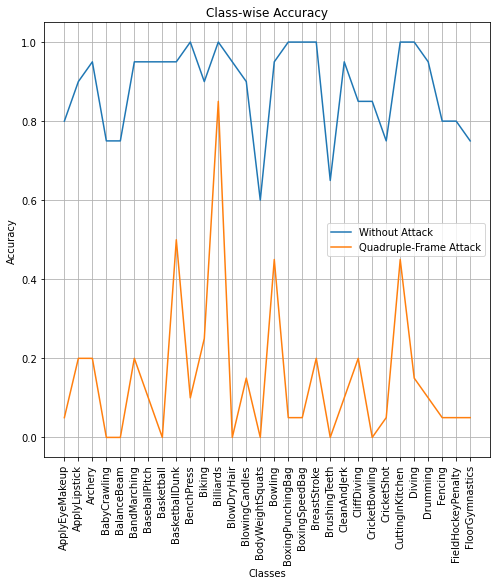

In [18]:
plt.figure(figsize=(8,8))
plt.title("Class-wise Accuracy")
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.grid()
X = np.arange(N)
plt.xticks(X, Classes, rotation=90)
for Acc, Desc in Results:
    plt.plot(X, Acc, label=Desc)
plt.legend()
plt.savefig("Results/Adversarial-Attack.eps")
plt.show()